In [5]:
import numpy as np
from scipy.signal import convolve2d #convolution
from imageio import imread #read image
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset,DataLoader,TensorDataset
from torchsummary import summary

#Convolution in numpy/scipy

Text(0.5, 1.0, 'Convolution Kernel')

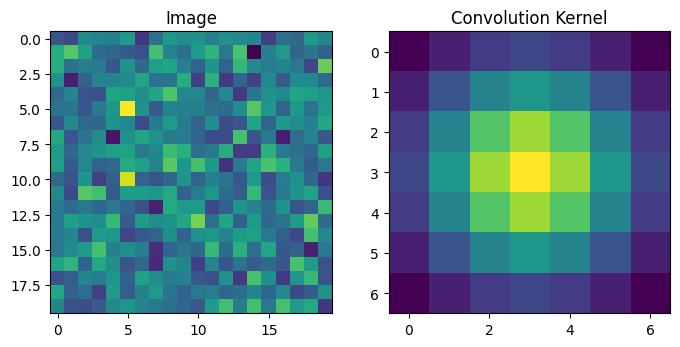

In [53]:
#image
imgN = 20
image = np.random.randn(imgN,imgN) #noise

#convolution kernel
kernelN = 7
x,y = np.meshgrid(np.linspace(-3,3,kernelN),np.linspace(-3,3,kernelN))
kernel = np.exp(-(x**2 + y**2)/7) #2D - gaussian kernel

fig, ax = plt.subplots(1,2,figsize = (8,6))
ax[0].imshow(image)
ax[0].set_title("Image")
ax[1].imshow(kernel)
ax[1].set_title("Convolution Kernel")

In [33]:
m = image[0:3,0:3]
kernel
fm = np.dot(m,kernel) #matrix multiplication
m*kernel #elementwise product

array([[-0.13773383,  0.0982073 ,  0.14411313],
       [ 0.42022895, -0.74976716,  0.16469246],
       [ 0.01564366,  0.09371842,  0.09965257]])

In [54]:
#implementing convolution in numpy
k = imgN-kernelN +1
fm = np.zeros([k,k])

for i in range(k):
  for j in range(k):
    m = image[i:i+kernelN,j:j+kernelN]
    fm[i,j] = np.sum(m*kernel)

In [55]:
#convolution in scipy
fm2 = convolve2d(image,kernel,mode = 'valid')

In [56]:
print(fm.shape)
print(fm2.shape)

(14, 14)
(14, 14)


Text(0.5, 1.0, 'Feature map (scipy)')

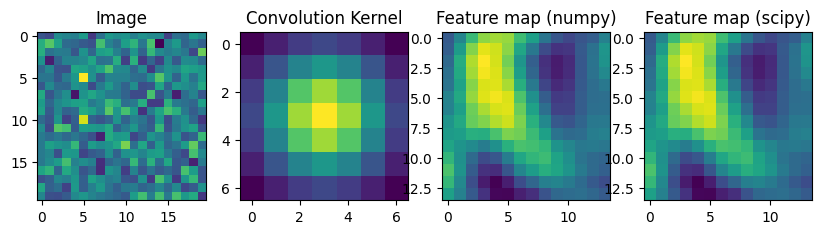

In [57]:
fig, ax = plt.subplots(1,4,figsize = (10,6))
ax[0].imshow(image)
ax[0].set_title("Image")
ax[1].imshow(kernel)
ax[1].set_title("Convolution Kernel")
ax[2].imshow(fm)
ax[2].set_title("Feature map (numpy)")
ax[3].imshow(fm2)
ax[3].set_title("Feature map (scipy)")

#Different Convolution Kernels

3D dimensions : (1675, 3000, 3)


/tmp/ipython-input-1600099269.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image1 = imread('/content/De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg')


Text(0.5, 1.0, 'Original image in 3D')

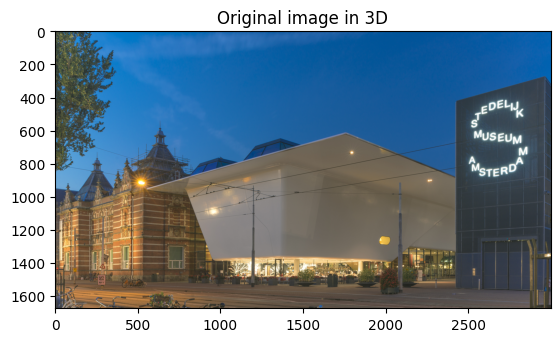

In [82]:
# read a pic
image1 = imread('/content/De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg')
#'https://upload.wikimedia.org/wikipedia/commons/4/47/PNG_transparency_demonstration_1.png')

print("3D dimensions :",image1.shape)
plt.imshow(image1)
plt.title("Original image in 3D")

Text(0.5, 1.0, 'Original image :RGB channel 2')

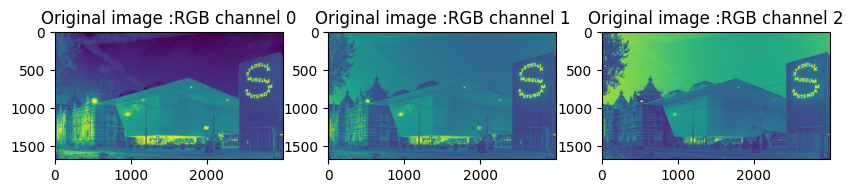

In [83]:
fig,ax = plt.subplots(1,3,figsize = (10,6))
ax[0].imshow(image1[:,:,0])
ax[0].set_title("Original image :RGB channel 0")
ax[1].imshow(image1[:,:,1])
ax[1].set_title("Original image :RGB channel 1")
ax[2].imshow(image1[:,:,2])
ax[2].set_title("Original image :RGB channel 2")

2D dimensions : (1675, 3000)


Text(0.5, 1.0, 'Transformed to 2D')

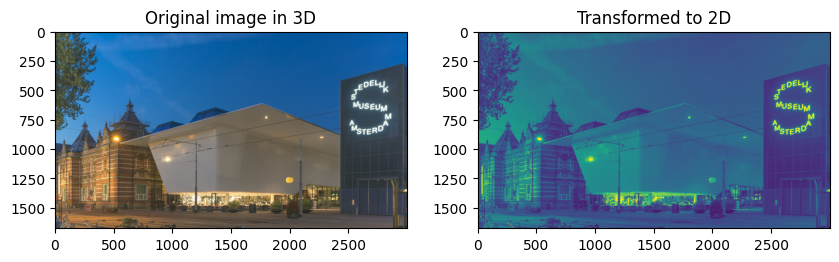

In [94]:
fig,ax = plt.subplots(1,2,figsize = (10,6))
ax[0].imshow(image1)
ax[0].set_title("Original image in 3D")

#transform image to 2D
image2 = np.mean(image1,axis = 2)
image2 = image2/np.max(image2)

print("2D dimensions :",image2.shape)

ax[1].imshow(image2)
ax[1].set_title("Transformed to 2D")

(3, 3)
(3, 3)
(3, 3)


Text(0.5, 1.0, 'Diagonal Kernel')

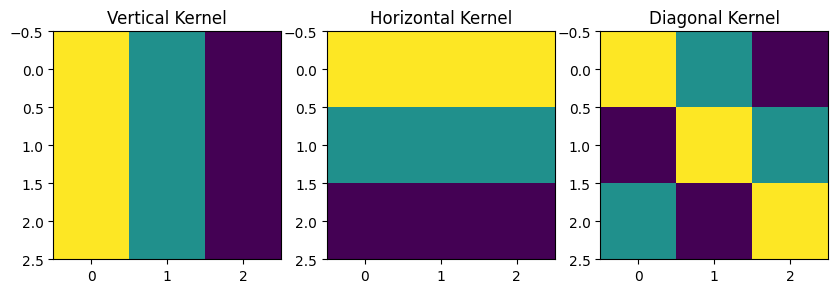

In [106]:
fig,ax = plt.subplots(1,3,figsize = (10,6))

#Vertical Kernel
vk = np.array([[1,0,-1],[1,0,-1],[1,0,-1]])
print(vk.shape)
ax[0].imshow(vk)
ax[0].set_title("Vertical Kernel")

#Horizontal Kernel
hk = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
print(hk.shape)
ax[1].imshow(hk)
ax[1].set_title("Horizontal Kernel")

#Diagonal Kernel
dk = np.array([[1,0,-1],[-1,1,0],[0,-1,1]])
print(dk.shape)
ax[2].imshow(dk)
ax[2].set_title("Diagonal Kernel")

Text(0.5, 1.0, 'Feature map diagonal')

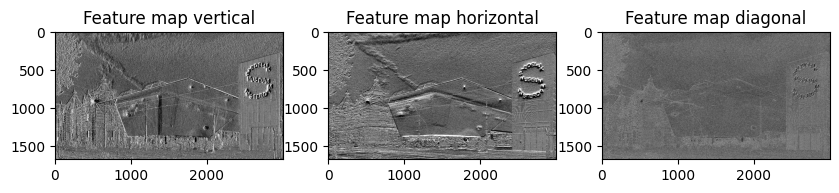

In [114]:
fmv = convolve2d(image2,vk,mode = "same")
fmh = convolve2d(image2,hk,mode = "same")
fmd = convolve2d(image2,dk,mode = "same")

fig,ax = plt.subplots(1,3,figsize = (10,6))
ax[0].imshow(fmv,cmap = "gray",vmin = 0,vmax = .01)
ax[0].set_title("Feature map vertical")

ax[1].imshow(fmh,cmap = "gray",vmin = 0,vmax = .01)
ax[1].set_title("Feature map horizontal")

ax[2].imshow(fmd,cmap = "gray",vmin = 0,vmax = .01)
ax[2].set_title("Feature map diagonal")

#Convolution in PyTorch

In [125]:
#changing to tensors and reshaping kernels
vk_t = torch.tensor(vk).view(1,1,3,3).double() #4D : (no of images in batch, channels,dim1 of image, dim2 of image)
hk_t = torch.tensor(hk).view(1,1,3,3).double() #4D
dk_t = torch.tensor(dk).view(1,1,3,3).double() #4D
image2_t = torch.tensor(image2).view(1,1,image2.shape[0],image2.shape[1]) #4D

print(vk_t.shape)
print(image2_t.shape)

torch.Size([1, 1, 3, 3])
torch.Size([1, 1, 1675, 3000])


In [130]:
cv = F.conv2d(image2_t,vk_t)
ch = F.conv2d(image2_t,hk_t)
cd = F.conv2d(image2_t,dk_t)
print(cv.shape)
print(ch.shape)
print(cd.shape)

torch.Size([1, 1, 1673, 2998])
torch.Size([1, 1, 1673, 2998])
torch.Size([1, 1, 1673, 2998])


Text(0.5, 1.0, 'Feature map diagonal')

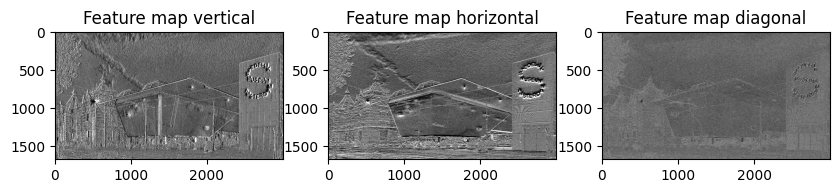

In [132]:
fig,ax = plt.subplots(1,3,figsize = (10,6))
img = torch.squeeze(cv.detach()) #removes singleton dimensions
ax[0].imshow(img,cmap = "gray",vmin = 0,vmax = .01)
ax[0].set_title("Feature map vertical")

img = torch.squeeze(ch.detach())
ax[1].imshow(img,cmap = "gray",vmin = 0,vmax = .01)
ax[1].set_title("Feature map horizontal")

img = torch.squeeze(cd.detach())
ax[2].imshow(img,cmap = "gray",vmin = 0,vmax = .01)
ax[2].set_title("Feature map diagonal")

#Conv2 class Pytorch

In [141]:
inChans = 3 #RGB
outChans = 15 #15 feature maps aka 15 kernels
krnSize = 5 #of the 15 kernes,each kernel is 5x5
stride = 1
padding = 0

#instance of conv2d class
c = nn.Conv2d(inChans,outChans,krnSize,stride,padding)

print(c)
print('size of weights',str(c.weight.shape))# feature maps (output channels) x input channels x kernel size
print('size of bias',str(c.bias.shape))

Conv2d(3, 15, kernel_size=(5, 5), stride=(1, 1))
size of weights torch.Size([15, 3, 5, 5])
size of bias torch.Size([15])


In [154]:
print("kernel 1")
print(c.weight[0,0,:,:],"\n")

print("kernel 2")
print(c.weight[0,1,:,:],"\n")

print("kernel 3")
print(c.weight[0,2,:,:])

kernel 1
tensor([[-0.0654,  0.0609,  0.0308,  0.0737, -0.0543],
        [ 0.0190,  0.0939,  0.0510,  0.0860,  0.0152],
        [-0.0593,  0.0602, -0.0867, -0.1079,  0.0870],
        [-0.0997,  0.0850,  0.0831, -0.0275, -0.0676],
        [-0.0491,  0.0310, -0.0328,  0.0381, -0.0183]],
       grad_fn=<SelectBackward0>) 

kernel 2
tensor([[ 0.0207,  0.0685, -0.0314,  0.1065, -0.0444],
        [ 0.0670,  0.0369,  0.0910,  0.0291, -0.0225],
        [ 0.0039, -0.0376, -0.0829, -0.0481, -0.0869],
        [-0.0372, -0.1018, -0.0777, -0.0005,  0.0298],
        [-0.0520, -0.0738, -0.0379,  0.1052,  0.0139]],
       grad_fn=<SelectBackward0>) 

kernel 3
tensor([[ 0.1119,  0.1020,  0.0069,  0.0845, -0.0108],
        [ 0.1129,  0.0355,  0.0691,  0.0536,  0.0718],
        [-0.0744, -0.0279, -0.0251, -0.1127, -0.0003],
        [-0.0810, -0.0194,  0.0788, -0.0953,  0.0171],
        [-0.0591,  0.0728, -0.1015,  0.1125,  0.0233]],
       grad_fn=<SelectBackward0>)


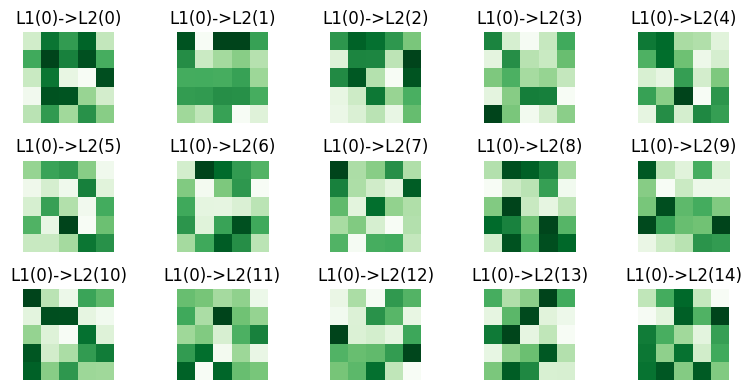

In [189]:
fig,axs = plt.subplots(3,5,figsize = (8,4))

for i,ax in enumerate(axs.flatten()):
  ax.imshow(torch.squeeze(c.weight[i,0,:,:]).detach(),cmap = "Greens")
  ax.set_title('L1(0)->L2(%s)'%i)
  ax.axis('off')

plt.tight_layout()

torch.Size([1, 3, 64, 64])
(64, 64, 3, 1)


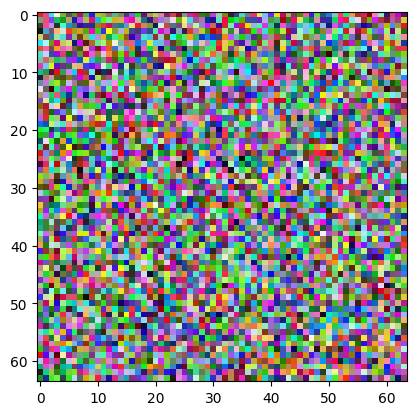

In [161]:
imsize = (1,3,64,64) #4D : (no of images in batch, RGB channels,dim1 of image (width), dim2 of image (height))
img = torch.rand(imsize)

img2view = img.permute(2,3,1,0).numpy() #pytorch wants channels first , matplotlib wants channels last
print(img.shape)
print(img2view.shape)

plt.imshow(np.squeeze(img2view))

In [190]:
#convolve the image with filter
convRes = c(img)
print(img.shape)
print(convRes.shape)

torch.Size([1, 3, 64, 64])
torch.Size([1, 15, 60, 60])


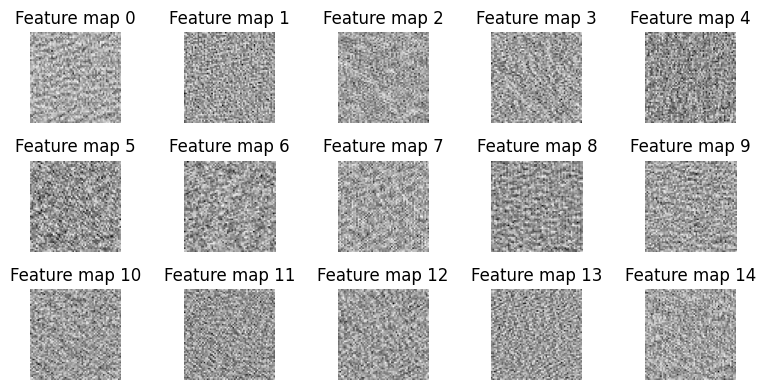

In [191]:
fig,axs = plt.subplots(3,5,figsize = (8,4))

for i,ax in enumerate(axs.flatten()):
  ax.imshow(torch.squeeze(convRes[0,i,:,:]).detach(),cmap = "Grays")
  ax.set_title('Feature map %s'%i)
  ax.axis('off')

plt.tight_layout()

In [178]:
print(image1.shape)
image1_t = torch.tensor(image1).view(1,3,1675,3000).float()
print(image1_t.shape)

(1675, 3000, 3)
torch.Size([1, 3, 1675, 3000])


In [180]:
convRes = c(image1_t)
print(convRes.shape)

torch.Size([1, 15, 1671, 2996])


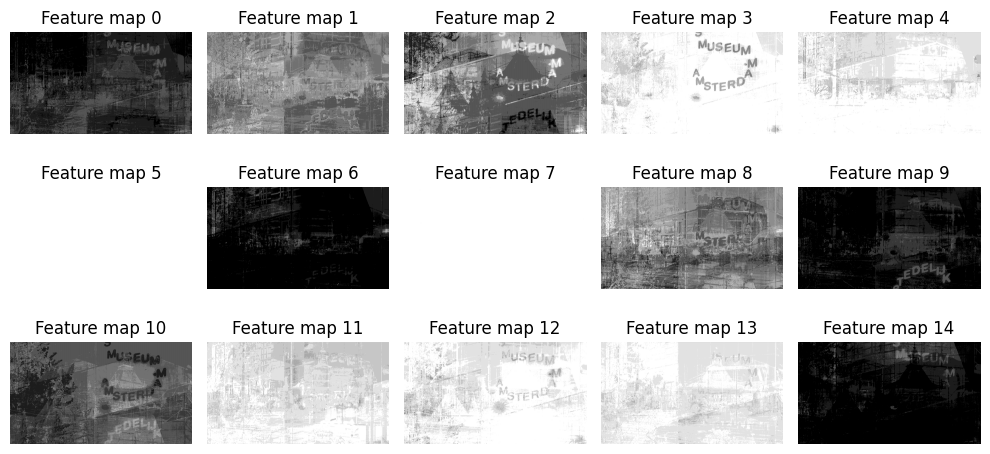

In [188]:
fig,axs = plt.subplots(3,5,figsize = (10,5))

for i,ax in enumerate(axs.flatten()):
  ax.imshow(torch.squeeze(convRes[0,i,:,:]).detach(),cmap = "Grays",vmin = 0,vmax = 0.5)
  ax.set_title('Feature map %s'%i)
  ax.axis('off')

plt.tight_layout()

#Transpose convolution

In [192]:
inChans = 3 #RGB
outChans = 15 #15 feature maps aka 15 kernels
krnSize = 5 #of the 15 kernes,each kernel is 5x5
stride = 1
padding = 0

#instance of conv2d class
#c = nn.Conv2d(inChans,outChans,krnSize,stride,padding)
c = nn.ConvTranspose2d(inChans,outChans,krnSize,stride,padding)

print(c)
print('size of weights',str(c.weight.shape))# feature maps (output channels) x input channels x kernel size
print('size of bias',str(c.bias.shape))

ConvTranspose2d(3, 15, kernel_size=(5, 5), stride=(1, 1))
size of weights torch.Size([3, 15, 5, 5])
size of bias torch.Size([15])


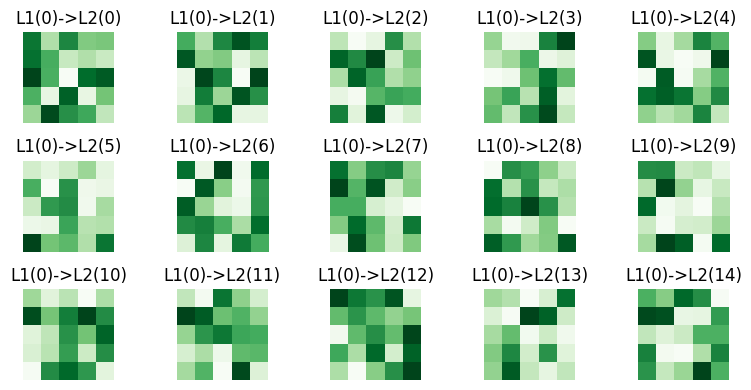

In [194]:
fig,axs = plt.subplots(3,5,figsize = (8,4))

for i,ax in enumerate(axs.flatten()):
  ax.imshow(torch.squeeze(c.weight[0,i,:,:]).detach(),cmap = "Greens")
  ax.set_title('L1(0)->L2(%s)'%i)
  ax.axis('off')

plt.tight_layout()

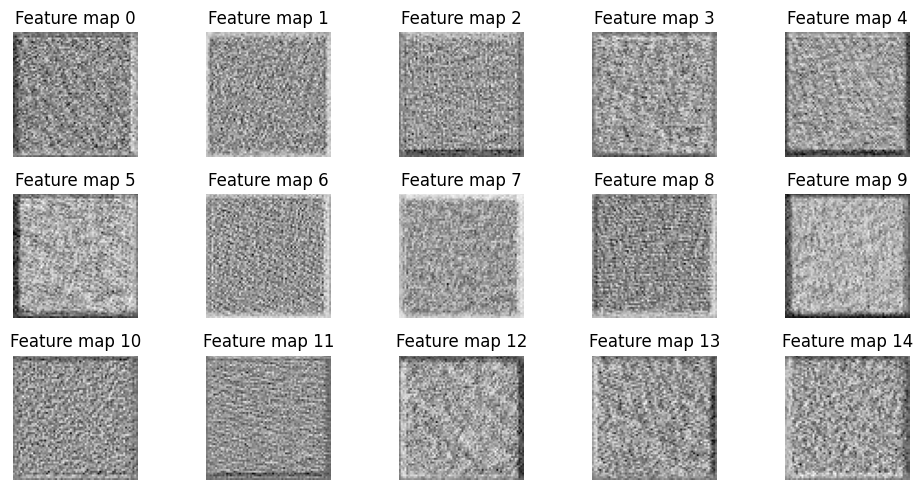

In [197]:
convRes = c(img)

fig,axs = plt.subplots(3,5,figsize = (10,5))

for i,ax in enumerate(axs.flatten()):
  ax.imshow(torch.squeeze(convRes[0,i,:,:]).detach(),cmap = "Grays")
  ax.set_title('Feature map %s'%i)
  ax.axis('off')

plt.tight_layout()

In [198]:
convRes = c(image1_t)
print(convRes.shape)

torch.Size([1, 15, 1679, 3004])


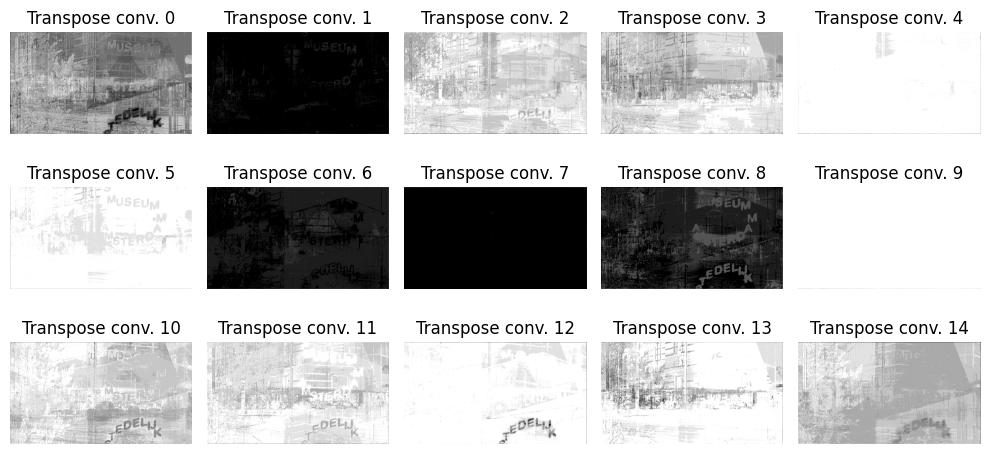

In [203]:
fig,axs = plt.subplots(3,5,figsize = (10,5))

for i,ax in enumerate(axs.flatten()):
  ax.imshow(torch.squeeze(convRes[0,i,:,:]).detach(),cmap = "Grays",vmin = 0,vmax = 0.5)
  ax.set_title('Transpose conv. %s'%i)
  ax.axis('off')

plt.tight_layout()

#Pooling

In [210]:
#kernel or spatial extent : no. of pixels in pooling window
#stride : same as stride in convolution i.e. no. of pixels to skip in each window

#parameters
poolSize = 3
stride = 3

#instance
p2 = nn.MaxPool2d(poolSize,stride)
p3 = nn.MaxPool3d(poolSize,stride)

print(p2) #ceiling mode is False for rounding down (avoiding edges); True for rounding up (including edges)
print(p3)

MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)


In [213]:
#create 2D, 3D image
img2 = torch.randn(1,1,30,30)
img3 = torch.randn(1,3,30,30)

img2_p2 = p2(img2)
print(f'2D image, 2D maxpooling : {img2_p2.shape}\n')

img3_p2 = p2(img3)
print(f'3D image, 2D maxpooling : {img3_p2.shape}\n')#generates 3 channels

img3_p3 = p3(img3)
print(f'3D image, 3D maxpooling : {img3_p3.shape}\n') #generates only 1 channel

2D image, 2D maxpooling : torch.Size([1, 1, 10, 10])

3D image, 2D maxpooling : torch.Size([1, 3, 10, 10])

3D image, 3D maxpooling : torch.Size([1, 1, 10, 10])



#Basic CNN

In [218]:
cnn0 = nn.Sequential(

    #convolution + pooling block
    nn.Conv2d(3,10,5,3,2), #inChans,outChans,krnSize,stride,padding
    nn.ReLU(), #activation function
    nn.AvgPool3d(3,3), #kernel,stride #downsampling #can be linear or non-linear

    #ANN block
    nn.Flatten(), #vectorize to make image linear
    nn.Linear(588,1),
    nn.Sigmoid()

)

print(cnn0)

Sequential(
  (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool3d(kernel_size=3, stride=3, padding=0)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=588, out_features=1, bias=True)
  (5): Sigmoid()
)


In [219]:
img = torch.randn(1,3,128,128)
cnn0(img)

tensor([[0.4664]], grad_fn=<SigmoidBackward0>)

#CIFAR Datasets

In [256]:
cdata = torchvision.datasets.CIFAR10(root = 'cifar10',download = True)

In [222]:
print(cdata)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10
    Split: Train


In [227]:
print(cdata.data.shape)
print(cdata.classes)
print(cdata.targets)
print(len(cdata.targets))

(50000, 32, 32, 3)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
[6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1, 2, 2, 9, 2, 6, 6, 1, 9, 5, 0, 4, 7, 6, 7, 1, 8, 1, 1, 2, 8, 1, 3, 3, 6, 2, 4, 9, 9, 5, 4, 3, 6, 7, 4, 6, 8, 5, 5, 4, 3, 1, 8, 4, 7, 6, 0, 9, 5, 1, 3, 8, 2, 7, 5, 3, 4, 1, 5, 7, 0, 4, 7, 5, 5, 1, 0, 9, 6, 9, 0, 8, 7, 8, 8, 2, 5, 2, 3, 5, 0, 6, 1, 9, 3, 6, 9, 1, 3, 9, 6, 6, 7, 1, 0, 9, 5, 8, 5, 2, 9, 0, 8, 8, 0, 6, 9, 1, 1, 6, 3, 7, 6, 6, 0, 6, 6, 1, 7, 1, 5, 8, 3, 6, 6, 8, 6, 8, 4, 6, 6, 1, 3, 8, 3, 4, 1, 7, 1, 3, 8, 5, 1, 1, 4, 0, 9, 3, 7, 4, 9, 9, 2, 4, 9, 9, 1, 0, 5, 9, 0, 8, 2, 1, 2, 0, 5, 6, 3, 2, 7, 8, 8, 6, 0, 7, 9, 4

In [225]:
type(cdata)

torchvision.datasets.cifar.CIFAR10

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]], dtype=uint8)
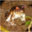

In [228]:
cdata.data[0]

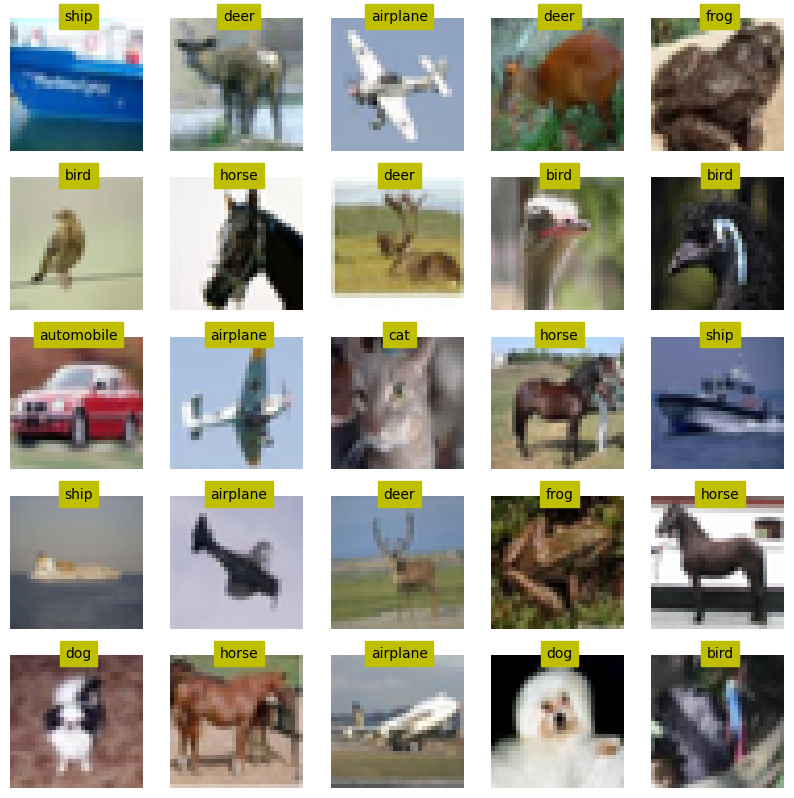

In [246]:
fig,axs = plt.subplots(5,5,figsize = (10,10))

for ax in axs.flatten():
  randidx = np.random.choice(len(cdata.targets))
  pic = cdata.data[randidx,:,:,:]
  label = cdata.classes[cdata.targets[randidx]]
  ax.imshow(pic)
  ax.text(16,0,label,ha = "center", color = "k",backgroundcolor = "y")
  ax.axis("off")

In [250]:
cdata100 = torchvision.datasets.CIFAR100(root = 'cifar100',download = True)

100%|██████████| 169M/169M [00:01<00:00, 96.1MB/s]


In [251]:
print(cdata100.data.shape)
print(cdata100.classes)
print(cdata100.targets)
print(len(cdata100.targets))

(50000, 32, 32, 3)
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'wha

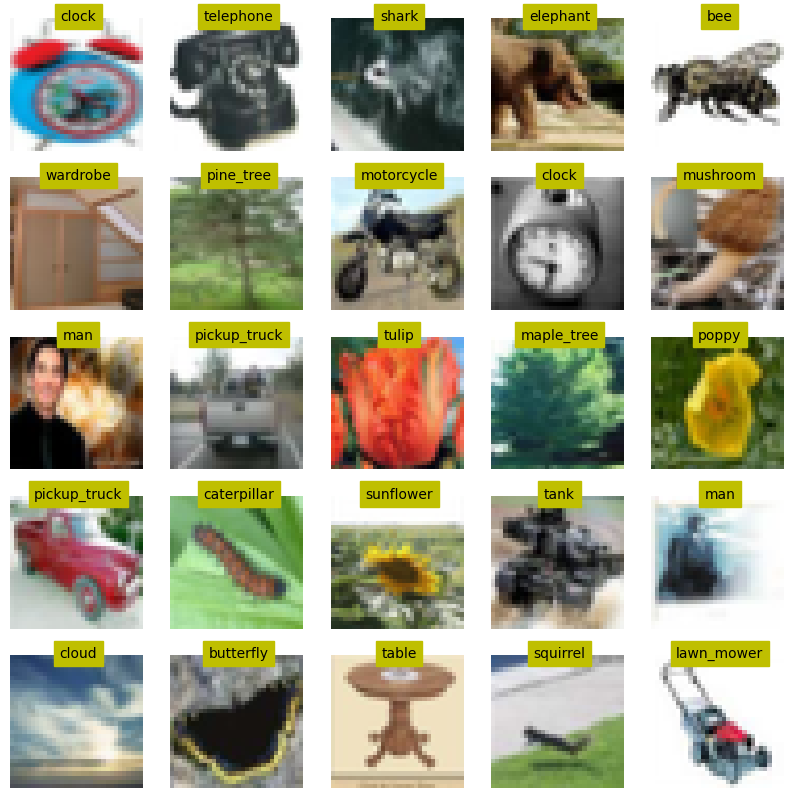

In [253]:
fig,axs = plt.subplots(5,5,figsize = (10,10))

for ax in axs.flatten():
  randidx = np.random.choice(len(cdata100.targets))
  pic = cdata100.data[randidx,:,:,:]
  label = cdata100.classes[cdata100.targets[randidx]]
  ax.imshow(pic)
  ax.text(16,0,label,ha = "center", color = "k",backgroundcolor = "y")
  ax.axis("off")

#Image Transforms

In [287]:
Ts = T.Compose([T.ToTensor(), #converts to tensor, normalizes data to lie between 0 to 1
                T.Resize(32*6), #increase resolution by factor of 4
                T.Grayscale(num_output_channels=1)])


cdata.transforms = Ts #include transforms in the dataset

print(cdata.data[0,:,:,:].shape) #tranformation has not been applied yet.

(32, 32, 3)


In [288]:
cdata = torchvision.datasets.CIFAR10(root = 'cifar10',download = True,transform = Ts)

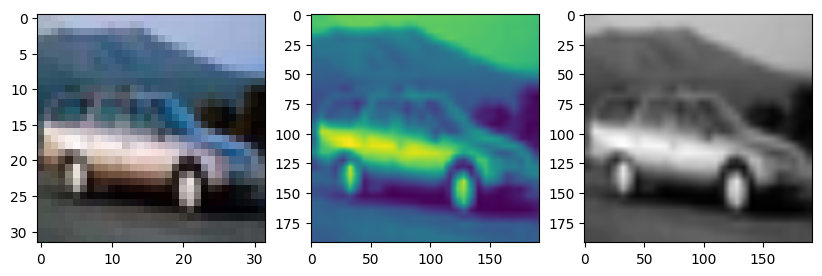

In [289]:
#apply tranforms externally
n = 4
img1 = Ts(cdata.data[n,:,:,:])

img2 = cdata.transform(cdata.data[n,:,:,:])

fig,ax = plt.subplots(1,3,figsize = (10,3))
ax[0].imshow(cdata.data[n,:,:,:])
ax[1].imshow(torch.squeeze(img1))
ax[2].imshow(torch.squeeze(img2),cmap = "gray")

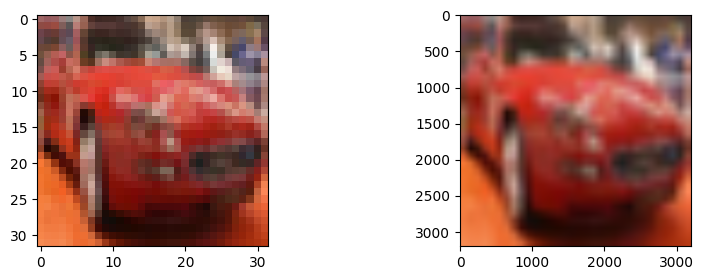

In [294]:
Ts2 = T.Compose([T.ToTensor(), #converts to tensor, normalizes data to lie between 0 to 1
                T.Resize(32*100) #increase resolution by factor of 4
                ])

n = 5
img1 = Ts2(cdata.data[n,:,:,:])

fig,ax = plt.subplots(1,2,figsize = (10,3))
ax[0].imshow(cdata.data[n,:,:,:])
ax[1].imshow(img1.permute(1,2,0))

In [304]:
data = np.loadtxt(open('/content/sample_data/mnist_train_small.csv','rb'),delimiter = ',')

#extract 8 records
labels = data[0:8,0]
data = data[0:8,1:]

#normalize
dataNorm = data/np.max(data)

#reshape to 2D
print(dataNorm.shape)
dataNorm = dataNorm.reshape(dataNorm.shape[0],1,28,28)
print(dataNorm.shape)

dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

(8, 784)
(8, 1, 28, 28)


In [307]:
??torch.utils.data.TensorDataset

In [319]:
class customDataset(Dataset):
  def __init__(self, tensors,transform = None):
          assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors), (
              "Size mismatch between tensors"
          )
          self.tensors = tensors
          self.transform = transform

  def __getitem__(self, index):

    if self.transform:
      x = self.transform(self.tensors[0][index])
    else:
      x = self.tensors[0][index]

    y = self.tensors[1][index]

    return x,y

  def __len__(self):
    return self.tensors[0].size(0)

In [320]:
#data -> custom dataset -> dataloader -> pull mini-batches -> apply transformations

imgtrans = T.Compose([
    T.ToPILImage(),
    T.RandomVerticalFlip(p=.5), # 50%probability to flip
    #T.RandomRotation(90),
    T.ToTensor()
])

train_data = customDataset((dataT,labelsT),imgtrans)
print(train_data)

Text(0, 0.5, 'Transformed')

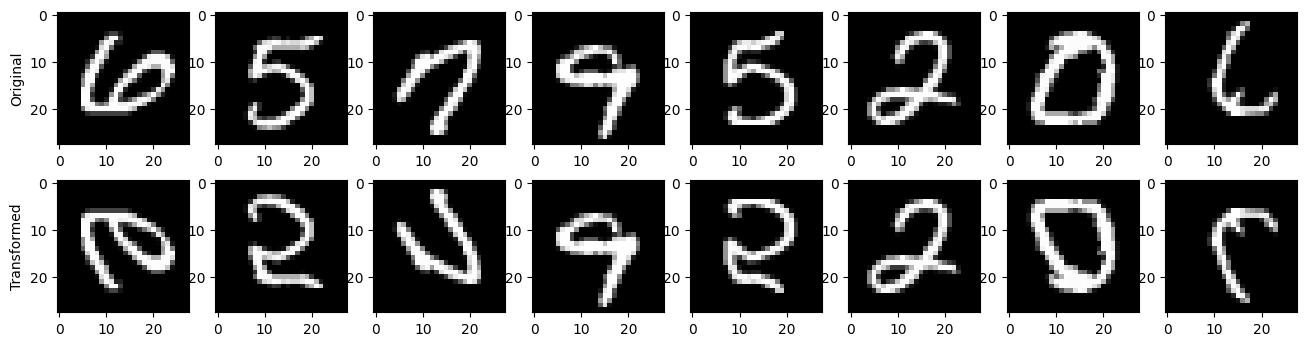

In [331]:
train_data_loader = DataLoader(train_data,batch_size = 8,shuffle = False)

x,y = next(iter(train_data_loader))

fig,ax = plt.subplots(2,8,figsize = (16,4))

for i in range(8):
  ax[0,i].imshow(dataT[i,0,:,:].detach(),cmap = 'gray')
  ax[1,i].imshow(x[i,0,:,:].detach(),cmap = 'gray')

ax[0,0].set_ylabel("Original")
ax[1,0].set_ylabel("Transformed")

#CNN : classify MNIST

###Architecture

  Image (1x28x28)

  Convolution Layer #1 - 10x26x26

  Pooling Layer #1 - 10x13x13

  Convolution Layer #2 - 20x11x11

  Pooling Layer #2 - Maxpool - 20x5x5

  Fully Connected Layer #1 - 1x50

  Output Layer #1 - 1x10

In [332]:
#CNN Layers --> Convolution Layer (learn kernels through backprop)
#CNN Layers --> Pooling Layer (reduce dimensionality, increase receptive field size)
#CNN Layers --> Fully Connected Layer (prediction - categorical or continuous)

In [14]:
data = np.loadtxt(open('/content/sample_data/mnist_train_small.csv','rb'),delimiter = ',')

labels = data[:,0]
data = data[:,1:]

#normalize
dataNorm = data/np.max(data)

#reshape to 2D
print(dataNorm.shape)
dataNorm = dataNorm.reshape(dataNorm.shape[0],1,28,28) #no. of images x channel x width x height
print(dataNorm.shape)

#convert to tensor
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

#split the data into train and test
train_data, test_data, train_labels, test_labels = train_test_split(dataT,labelsT,test_size = 0.1)

#define tranformations
'''imgtrans = T.Compose([
  T.ToPILImage(),
  T.RandomVerticalFlip(p=.5), # 50%probability to flip
  #T.RandomRotation(90),
  T.ToTensor()
])'''

#create tensor or custom datasets
'''train_data = customDataset((dataT,labelsT),imgtrans)
print(train_data)'''

train_dataset = TensorDataset(train_data,train_labels)
test_dataset = TensorDataset(test_data,test_labels)

#DataLoader
batchsize = 32
train_loader = DataLoader(train_dataset,batch_size = batchsize , shuffle = True, drop_last = True)
test_loader = DataLoader(test_dataset,batch_size = test_dataset.tensors[0].shape[0])
print("train dataloader dimensions :",train_loader.dataset.tensors[0].shape) # no. of images x channel x width x height

(20000, 784)
(20000, 1, 28, 28)
train dataloader dimensions : torch.Size([18000, 1, 28, 28])


In [29]:
def cnn_initialization_1(printtoggle = False):

  class cnn_arch_1(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      #input 20000x1x28x28

      #convolution layer#1 10x26x26
      self.conv1 = nn.Conv2d(1,10,kernel_size = 5,stride = 1,padding = 1)#inChans,outChans,krnSize,stride,padding
      #size of output : np.floor((28+2*1-5)/1)+1 = 26
      #maxpooling layer output : 26/2 = 13
      #10x13x13

      #convolution layer#2 10x26x26
      self.conv2 = nn.Conv2d(10,20,kernel_size = 5,stride = 1,padding = 1)
      #size of output : np.floor((13 + 2*1 - 5)/1) + 1 = 11
      #maxpooling layer output : 11/2 ~ 5
      #20x5x5

      expectedSize = 20*5*5
      print("input to fc1 :",expectedSize)

      #fully connected layer
      self.fc1 = nn.Linear(expectedSize,50)

      #output  layer
      self.out = nn.Linear(50,10)

      #toggle for printing out tensor sizes during forward prop
      self.print = printtoggle

    def forward(self,x):
      def print_fun(msg,x):
        if self.print:
          print(msg,x.shape)

      print_fun("input layer: ",x)

      #convolution -> maxpooling -> relu
      x = F.relu(F.max_pool2d(self.conv1(x),kernel_size = 2))
      print_fun("cov/pool layer1: ",x)

      x = F.relu(F.max_pool2d(self.conv2(x),kernel_size = 2))
      print_fun("cov/pool layer2: ",x)

      #reshape / vectorize for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      y = x

      x = x.view(-1,int(nUnits))
      print_fun("vectorize: ",x)

      #y = y.flatten() #this will not work
      #print_fun("flatten",y)

      x = F.relu(self.fc1(x))
      print_fun("fc1: ",x)

      x = self.out(x)
      print_fun("output: ",x)

      return x

  model = cnn_arch_1(printtoggle)
  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

  return model,lossfun,optimizer

In [32]:
model,lossfun,optimizer = cnn_initialization_1(True)
x,y = next(iter(train_loader))
yhat = model(x)
print()
print("yhat shape",yhat.shape)
loss = lossfun(yhat,y)
print("Loss",loss)

input to fc1 : 500
input layer:  torch.Size([32, 1, 28, 28])
cov/pool layer1:  torch.Size([32, 10, 13, 13])
cov/pool layer2:  torch.Size([32, 20, 5, 5])
vectorize:  torch.Size([32, 500])
fc1:  torch.Size([32, 50])
output:  torch.Size([32, 10])

yhat shape torch.Size([32, 10])
Loss tensor(2.2990, grad_fn=<NllLossBackward0>)


In [34]:
summary(model,(1,28,28))

input layer:  torch.Size([2, 1, 28, 28])
cov/pool layer1:  torch.Size([2, 10, 13, 13])
cov/pool layer2:  torch.Size([2, 20, 5, 5])
vectorize:  torch.Size([2, 500])
fc1:  torch.Size([2, 50])
output:  torch.Size([2, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             260
            Conv2d-2           [-1, 20, 11, 11]           5,020
            Linear-3                   [-1, 50]          25,050
            Linear-4                   [-1, 10]             510
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.12
Estimated Total Size (MB): 0.19
----------------------------------------------------------------


In [38]:
#training
def training(model,lossfun,optimizer,numepochs,train_loader,test_loader):

  #initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []

  #loop over epochs
  for epochi in range(numepochs):

    #loop over training data batches

    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = model(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      #loss from this batch
      batchLoss.append(loss.item())

      #compute accuracy
      matches = torch.argmax(yHat,axis=1) == y
      matchesNumeric = matches.float()
      accuracyPct = 100*torch.mean(matchesNumeric)
      batchAcc.append( accuracyPct )


    #average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    #average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    #test accuracy
    model.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = model(X)

    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
    model.train()


  return trainAcc,testAcc,losses,model


In [39]:
numepochs = 10
model,lossfun,optimizer = cnn_initialization_1(False)
trainAcc,testAcc,losses,model = training(model,lossfun,optimizer,numepochs,train_loader,test_loader)

input to fc1 : 500


test accuracy  98.0
train accuracy  99.4


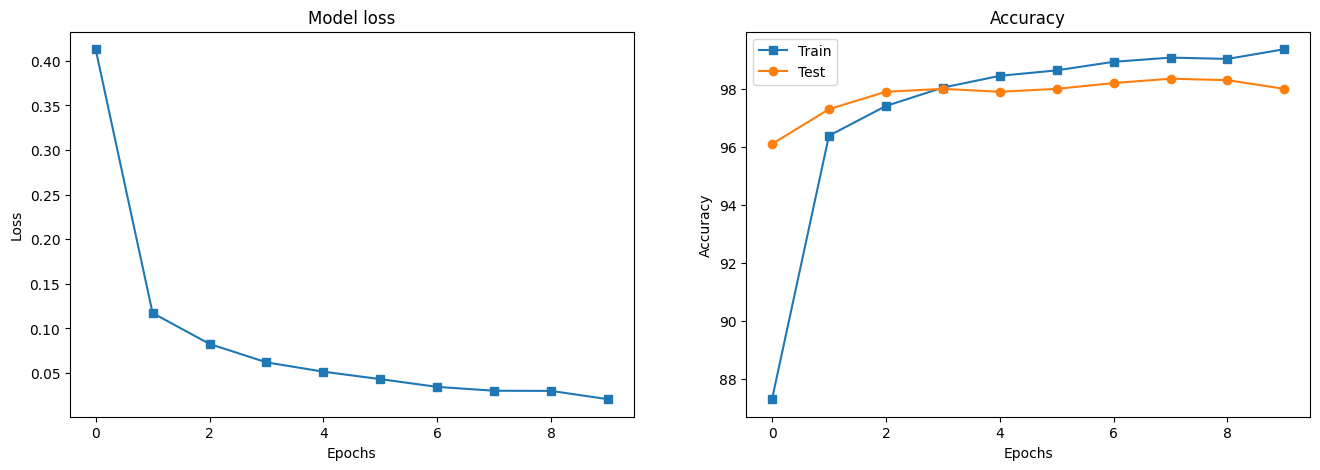

In [47]:
fig,ax = plt.subplots(1,2,figsize = (16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Model loss")

ax[1].plot(trainAcc,'s-',label = "Train")
ax[1].plot(testAcc,'o-',label = "Test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy")
ax[1].legend()

print("test accuracy ",testAcc[-1].item())
print("train accuracy ",round(trainAcc[-1],1))